In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_folder_path = '/content/drive/'


Mounted at /content/drive


In [3]:
# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/Work with Nayab/Siezues-GNN_RESULTS/Data/paitent.csv")  # Replace with the actual file path

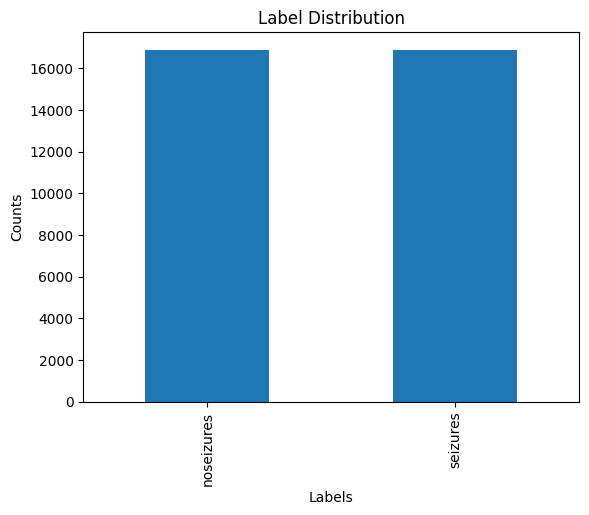

In [4]:
# Visualize the label column
label_counts = data['label'].value_counts()
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution')
plt.show()

In [5]:
# Separate features and labels
X = data.drop("label", axis=1)
y = data["label"]

In [6]:
# Convert labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [7]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [8]:
# Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Convert the data to TensorFlow tensors
X_train_tensor = tf.constant(X_train_scaled, dtype=tf.float32)
y_train_tensor = tf.constant(y_train, dtype=tf.int32)
X_test_tensor = tf.constant(X_test_scaled, dtype=tf.float32)
y_test_tensor = tf.constant(y_test, dtype=tf.int32)

In [10]:
import tensorflow as tf

class SimpleRNNModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(SimpleRNNModel, self).__init__()
        self.rnn_layer = tf.keras.layers.SimpleRNN(32, activation='relu')
        self.dense_output = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        expanded_inputs = tf.expand_dims(inputs, axis=-1)
        x = self.rnn_layer(expanded_inputs)
        output = self.dense_output(x)
        return output

In [11]:
num_classes = len(label_encoder.classes_)
model = SimpleRNNModel(num_classes)  # Replace 'GNNModel' with the appropriate LSTM model class
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
epochs = 50
batch_size = 32
steps_per_epoch = len(X_train_scaled) // batch_size
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

In [12]:
# Parameters for Early Stopping
patience = 5
best_loss = float('inf')
wait = 0
validation_split = 0.1  # Use a small validation set for faster evaluation

# Split a portion of training data for validation
val_size = int(len(X_train_tensor) * validation_split)
X_val_tensor = X_train_tensor[:val_size]
y_val_tensor = y_train_tensor[:val_size]
X_train_tensor = X_train_tensor[val_size:]
y_train_tensor = y_train_tensor[val_size:]

for epoch in range(epochs):
    for step in range(steps_per_epoch):
        # Mini-batch gradient updates
        start = step * batch_size
        end = (step + 1) * batch_size
        X_batch = X_train_tensor[start:end]
        y_batch = y_train_tensor[start:end]

        with tf.GradientTape() as tape:
            predictions = model(X_batch)
            loss = loss_object(y_batch, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Evaluate on validation data
    val_loss = loss_object(y_val_tensor, model(X_val_tensor))
    val_predictions = np.argmax(model(X_val_tensor).numpy(), axis=1)
    val_accuracy = accuracy_score(y_val_tensor.numpy(), val_predictions)

    train_loss_history.append(loss.numpy())
    test_loss_history.append(val_loss.numpy())
    train_accuracy_history.append(None)  # Skipping full train accuracy for speed
    test_accuracy_history.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        wait = 0  # Reset patience counter
    else:
        wait += 1
        print(f"No improvement in validation loss for {wait} epoch(s).")
        if wait >= patience:
            print("Early stopping triggered. Stopping training.")
            break

Epoch 1/50, Val Loss: 0.1825, Val Accuracy: 0.9401
Epoch 2/50, Val Loss: 0.1340, Val Accuracy: 0.9575
Epoch 3/50, Val Loss: 0.1392, Val Accuracy: 0.9545
No improvement in validation loss for 1 epoch(s).
Epoch 4/50, Val Loss: 0.1130, Val Accuracy: 0.9637
Epoch 5/50, Val Loss: 0.1075, Val Accuracy: 0.9678
Epoch 6/50, Val Loss: 0.1120, Val Accuracy: 0.9656
No improvement in validation loss for 1 epoch(s).
Epoch 7/50, Val Loss: 0.1280, Val Accuracy: 0.9567
No improvement in validation loss for 2 epoch(s).
Epoch 8/50, Val Loss: 0.1440, Val Accuracy: 0.9504
No improvement in validation loss for 3 epoch(s).
Epoch 9/50, Val Loss: 0.1850, Val Accuracy: 0.9327
No improvement in validation loss for 4 epoch(s).
Epoch 10/50, Val Loss: 0.1033, Val Accuracy: 0.9674
Epoch 11/50, Val Loss: 0.0934, Val Accuracy: 0.9730
Epoch 12/50, Val Loss: 0.1070, Val Accuracy: 0.9674
No improvement in validation loss for 1 epoch(s).
Epoch 13/50, Val Loss: 0.0867, Val Accuracy: 0.9723
Epoch 14/50, Val Loss: 0.0850, Va

In [13]:
# Evaluation
y_pred_train_prob = model(X_train_tensor).numpy()
y_pred_test_prob = model(X_test_tensor).numpy()

# Convert probabilities to class indices
y_pred_train = np.argmax(y_pred_train_prob, axis=1)
y_pred_test = np.argmax(y_pred_test_prob, axis=1)


In [14]:
# Evaluation
y_pred_train_prob = model(X_train_tensor).numpy() # This is making predictions on the validation training set
y_pred_test_prob = model(X_test_tensor).numpy()

# Convert probabilities to class indices
y_pred_train = np.argmax(y_pred_train_prob, axis=1)
y_pred_test = np.argmax(y_pred_test_prob, axis=1)

# F1 Score
# y_train_tensor contains the labels for the validation training set. We need to call .numpy()
# to change it to a numpy array so it's compatible with other arrays for the scoring function
f1_train = f1_score(y_train_tensor.numpy(), y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

# Accuracy
train_accuracy = np.mean(np.equal(y_train_tensor.numpy(), y_pred_train))
test_accuracy = np.mean(np.equal(y_test, y_pred_test))

# Other metrics
print("Train F1 Score:", f1_train)
print("Test F1 Score:", f1_test)

# Accuracy
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train F1 Score: 0.9734359219119019
Test F1 Score: 0.9743883415698735
Train Accuracy: 0.9734484175914508
Test Accuracy: 0.9744044977067614


In [15]:
y_pred_train_prob = model(X_train_tensor).numpy()
y_pred_test_prob = model(X_test_tensor).numpy()

# Convert probabilities to class indices
y_pred_train = np.argmax(y_pred_train_prob, axis=1)
y_pred_test = np.argmax(y_pred_test_prob, axis=1)

# Use y_train_tensor.numpy() instead of y_train for the training confusion matrix
cm_train = confusion_matrix(y_train_tensor.numpy(), y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

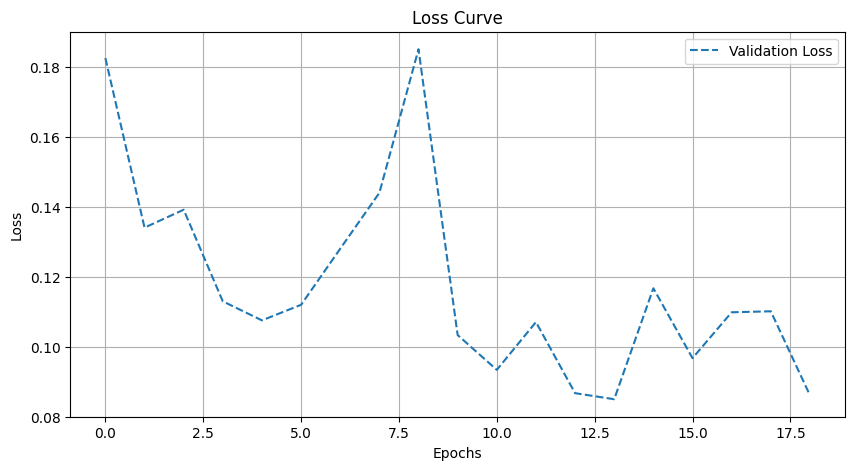

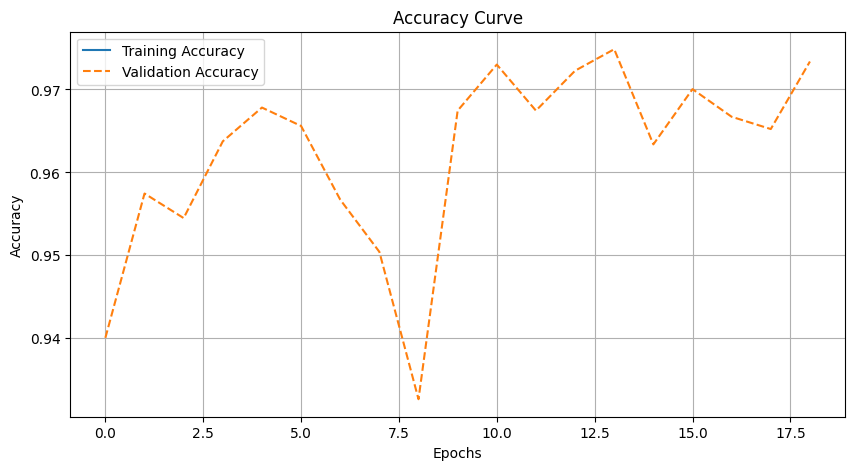

In [16]:
import matplotlib.pyplot as plt

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Training Loss")
plt.plot(test_loss_history, label="Validation Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_history, label="Training Accuracy")
plt.plot(test_accuracy_history, label="Validation Accuracy", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid()
plt.show()


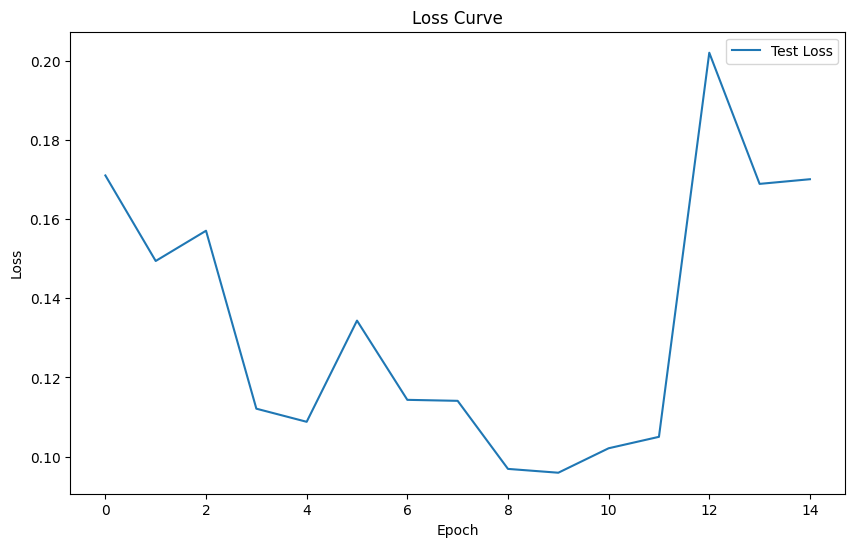

In [ ]:
# Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [ ]:
y_pred_train_prob = model(X_train_tensor).numpy()
y_pred_test_prob = model(X_test_tensor).numpy()

# Convert probabilities to class indices
y_pred_train = np.argmax(y_pred_train_prob, axis=1)
y_pred_test = np.argmax(y_pred_test_prob, axis=1)

# Classification Report
# Now y_train_tensor and y_pred_train are compatible (assuming y_train_tensor was used for training)
report_train = classification_report(y_train_tensor.numpy(), y_pred_train, target_names=label_encoder.classes_)
report_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

In [ ]:
# Print Confusion Matrix and Classification Report
print("Train Classification Report:")
print(report_train)

Train Classification Report:
              precision    recall  f1-score   support

  noseizures       0.89      1.00      0.94     10916
    seizures       1.00      0.87      0.93     10981

    accuracy                           0.94     21897
   macro avg       0.94      0.94      0.94     21897
weighted avg       0.94      0.94      0.94     21897



In [ ]:
print("Test Classification Report:")
print(report_test)

Test Classification Report:
              precision    recall  f1-score   support

  noseizures       0.90      1.00      0.95      3404
    seizures       1.00      0.88      0.94      3355

    accuracy                           0.94      6759
   macro avg       0.95      0.94      0.94      6759
weighted avg       0.95      0.94      0.94      6759



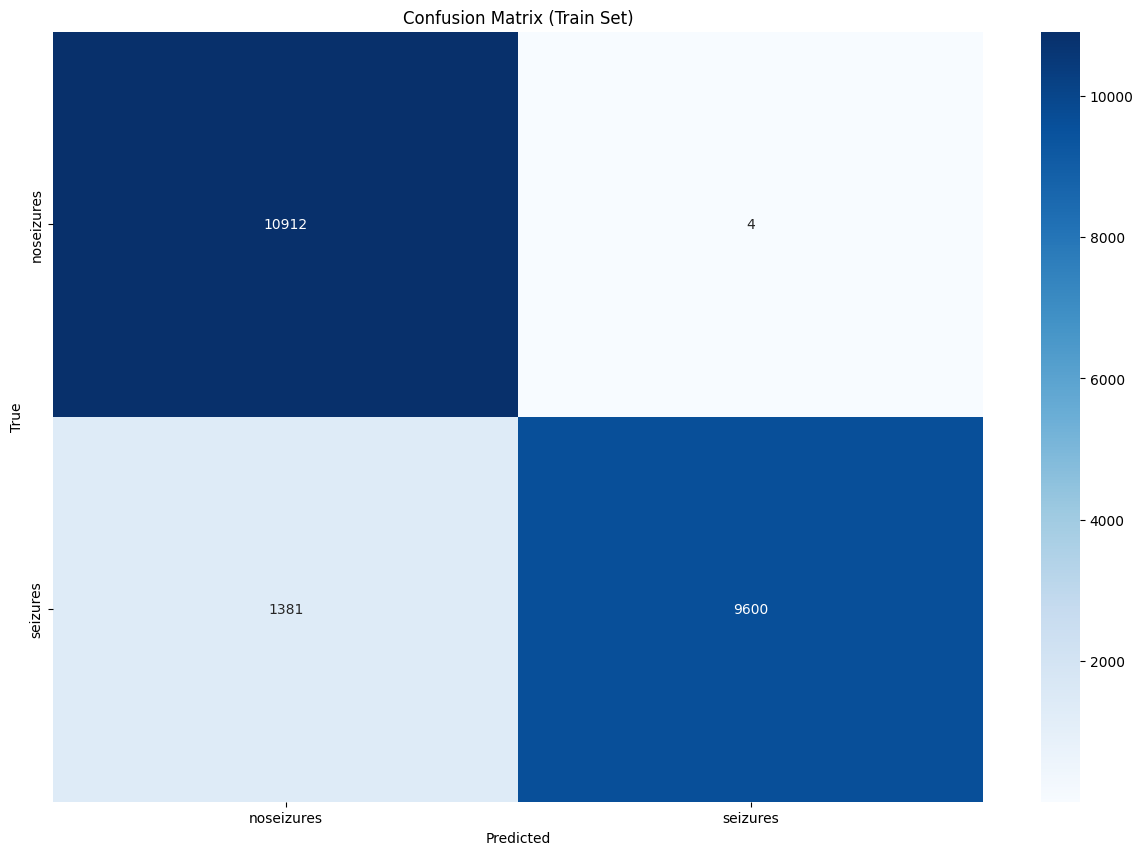

In [ ]:
# Plot Confusion Matrix Heatmap for Train Set
plt.figure(figsize=(15, 10))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Train Set)')
plt.show()

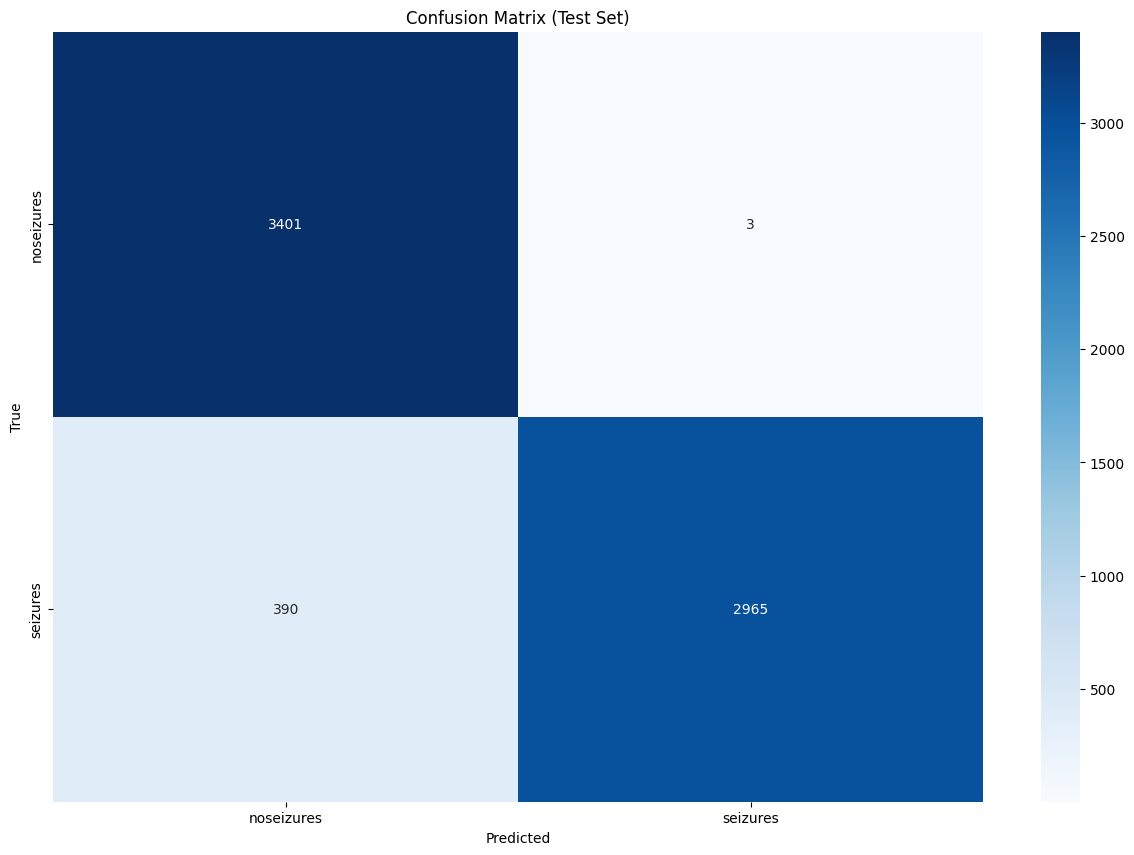

In [ ]:
# Plot Confusion Matrix Heatmap for Test Set
plt.figure(figsize=(15, 10))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

In [ ]:
print(y_train.shape)


(27033,)


ROC AUC Train: 0.9790351406969011
ROC AUC Test: 0.9789373770842054


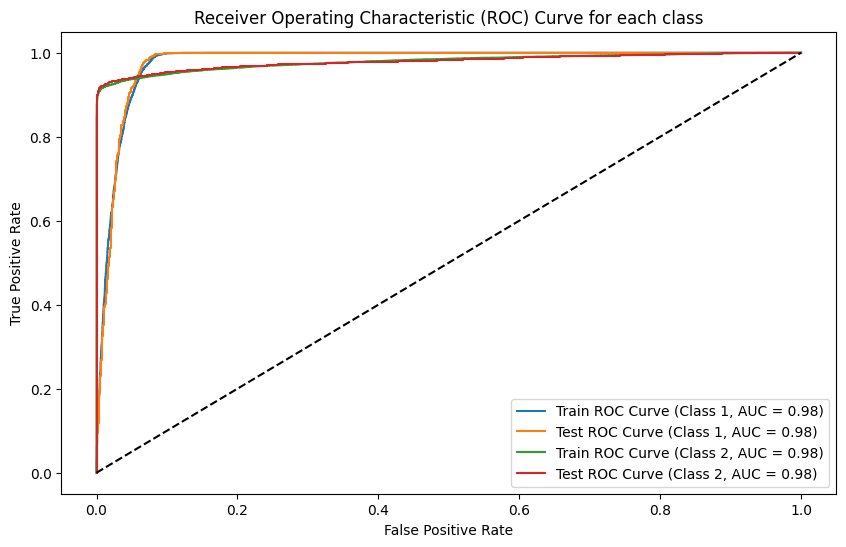

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

# Assuming y_pred_train_prob and y_pred_test_prob are the predicted probabilities for each class
# Extract the probabilities for each class
y_pred_train_prob = model(X_train_tensor).numpy()
y_pred_test_prob = model(X_test_tensor).numpy()

# Convert probabilities to class indices
y_pred_train = np.argmax(y_pred_train_prob, axis=1)
y_pred_test = np.argmax(y_pred_test_prob, axis=1)

# Calculate ROC AUC score for each class
roc_auc_train = []
roc_auc_test = []

# Use y_train_tensor.numpy() for training ROC AUC calculation to match the shape of y_pred_train_prob
for i in range(num_classes):  # Replace num_classes with the actual number of classes
    roc_auc_train.append(roc_auc_score(y_train_tensor.numpy() == i, y_pred_train_prob[:, i]))
    roc_auc_test.append(roc_auc_score(y_test == i, y_pred_test_prob[:, i]))

# Print or use roc_auc_train and roc_auc_test as needed
print("ROC AUC Train:", np.mean(roc_auc_train))
print("ROC AUC Test:", np.mean(roc_auc_test))

# Plot ROC curves
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    # Use y_train_tensor.numpy() for training ROC curve calculation
    fpr_train, tpr_train, _ = roc_curve(y_train_tensor.numpy() == i, y_pred_train_prob[:, i])
    roc_auc_train_class = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (Class {i + 1}, AUC = {roc_auc_train_class:.2f})')

    fpr_test, tpr_test, _ = roc_curve(y_test == i, y_pred_test_prob[:, i])
    roc_auc_test_class = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (Class {i + 1}, AUC = {roc_auc_test_class:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for each class')
plt.legend()
plt.show()

In [ ]:
import time
import numpy as np

# Start time for training predictions
start_train_time = time.time()
y_pred_train_prob = model(X_train_tensor).numpy()
end_train_time = time.time()

# Convert probabilities to class indices for training predictions
y_pred_train_prob = np.argmax(y_pred_train_prob, axis=1)

# Calculate time taken for training predictions
train_time = end_train_time - start_train_time
print(f"Time taken for training predictions: {train_time:.4f} seconds")

# Start time for testing predictions
start_test_time = time.time()
y_pred_test_prob = model(X_test_tensor).numpy()
end_test_time = time.time()

# Convert probabilities to class indices for testing predictions
y_pred_test_prob = np.argmax(y_pred_test_prob, axis=1)

# Calculate time taken for testing predictions
test_time = end_test_time - start_test_time
print(f"Time taken for testing predictions: {test_time:.4f} seconds")


Time taken for training predictions: 0.2411 seconds
Time taken for testing predictions: 0.1234 seconds
